In [354]:
import os
# import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.model_selection import train_test_split

%matplotlib inline

In [355]:
RANDOM_SEED=42
df_sequential = pd.read_csv('subsequences_raw.csv')
df_sequential_new_user = pd.read_csv('subsequences_test_raw.csv') # User 186
df_sequential.head()


,new_user_id,total_acc,x_acc,y_acc,z_acc,num_of_samples,signal_length_in_sec
0,0,"[0.7362116837612153, 0.8161704566822283, 2.322...","[0.2941316, -0.49968776, -2.1783454, -2.797762...","[-0.6356053, -0.6044512, 0.7134906, 1.3548992,...","[-0.22693644, -0.22602014, 0.37201694, -0.2776...",40,2
1,0,"[1.3777305229373487, 1.5960753374387007, 1.203...","[1.1114693, 1.215011, 0.9126327, 0.21197024, 0...","[-0.6337727, -0.82894415, -0.40378192, -0.9318...","[-0.5109888, -0.6197228, -0.67347896, -0.37812...",40,2
2,0,"[2.425892007118064, 3.302566174850101, 1.90556...","[1.4813483, 2.0045543, 1.8689423, 1.7660115, 0...","[-1.9147571, -2.6212227, -0.3643811, -3.342960...","[-0.15577064, -0.1337795, -0.07391469, -0.0665...",40,2
3,0,"[0.9513855617281761, 1.9683277319562844, 1.314...","[0.66767573, -1.0225884, 0.19639318, -0.015882...","[-0.6423248, 1.6542231, 1.2999213, -1.4358387,...","[0.21624629, -0.3036, 0.019242255, -0.42760566...",40,2
4,0,"[2.329359891123871, 1.6620954042937637, 0.8495...","[-1.8026633, -0.8240572, 0.4560109, 1.2605205,...","[1.3573426, 1.325883, 0.46822822, -0.1301143, ...","[0.57787853, 0.5705481, 0.54275376, 0.66553766...",40,2


In [394]:
def prepare_data(df_sequential):
    """
    Prepares the sequential data for further processing.

    Args:
        df_sequential (pd.DataFrame): DataFrame containing the sequential data.

    Returns:
        tuple: Processed feature data (X_data) and labels (y_sequential)
    """
    # Drop unnecessary columns and separate features and labels
    X_sequential = df_sequential.drop(columns=['new_user_id', 'num_of_samples', 'signal_length_in_sec'])
    y_sequential = df_sequential['new_user_id']

    # # Extract the number of samples
    # num_of_samples = df_sequential['num_of_samples'].iloc[0]

    # Convert the lists in 'total_acc', 'x_acc', 'y_acc', 'z_acc' columns to numpy arrays
    def convert_to_array(series: pd.Series):
        return np.array(series.apply(eval).to_list())

    X_total_acc = convert_to_array(X_sequential['total_acc'])
    X_x_acc = convert_to_array(X_sequential['x_acc'])
    X_y_acc = convert_to_array(X_sequential['y_acc'])
    X_z_acc = convert_to_array(X_sequential['z_acc'])

    # Stack the accelerometer data along the last dimension
    X_data = np.stack((X_total_acc, X_x_acc, X_y_acc, X_z_acc), axis=-1)

    # Ensure the shape is correct (samples, timesteps, features)
    print(X_data.shape)  # Expected: (num_samples, num_of_samples, 4)

    return X_data, y_sequential


X_data, y_sequential = prepare_data(df_sequential)
X_data_new_user, y_sequential_new_user = prepare_data(df_sequential_new_user)

# Split the data
X_train_sequential, X_temp, y_train_sequential, y_temp = train_test_split(X_data, y_sequential, test_size=0.3, random_state=RANDOM_SEED)

X_test_sequential, X_val, y_test_sequential, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED)

X_train_new_user, X_test_new_user, y_train_new_user, y_test_new_user = train_test_split(X_data_new_user, y_sequential_new_user, test_size=0.2, random_state=RANDOM_SEED)

(30993, 40, 4)
(312, 40, 4)


In [403]:
num_classes = (y_sequential.nunique()+2) # +1 Mandatory, +1 as we removed one user for the test set
input_shape = (X_train_sequential.shape[1], X_train_sequential.shape[2])  # timesteps, features


print(num_classes, input_shape)

192 (40, 4)


In [404]:
from collections import Counter
def majority_voting(model_output):
    """
    Predicts the majority class based on n model outputs.
    If only one sample is provided, the majority class is the predicted class.
    """
    predicted_classes = np.argmax(model_output, axis=1)
    counter = Counter(predicted_classes)
    majority_class = counter.most_common(1)[0][0]
    return majority_class

In [419]:
def create_lstm_model(input_shape, num_classes=10):
    """Creates a Keras LSTM model for accelerometer data classification.

    Args:
        input_shape (tuple): Shape of the input data (time_steps, features).
        num_classes (int): Number of classes for classification (default: 10).

    Returns:
        keras.Model: The compiled LSTM model.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape, name="input_acceleration"),

        # LSTM layers
        tf.keras.layers.LSTM(64, return_sequences=True, name="lstm_1", seed=RANDOM_SEED), 
        tf.keras.layers.LSTM(32, name="lstm_2", seed=RANDOM_SEED), 

        # Dense layers for classification
        tf.keras.layers.Dense(64, activation="relu", name="dense_1"),
        tf.keras.layers.Dropout(0.5, name='dropout', seed=RANDOM_SEED),  # Add dropout for regularization
        tf.keras.layers.Dense(num_classes, activation="softmax", name="baselayer")
    ], name="pretrained_base")

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam', #tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=["accuracy"],
    )
    return model

In [420]:
base_model = create_lstm_model(input_shape, num_classes=num_classes)
base_model.summary()

Model: "pretrained_base"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 40, 64)            │     17,664 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)                │     12,416 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 64)                │      2,112 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ baselayer (Dense)               │ (None, 192)               │     12,480 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 44,672 (174.50 KB)

 Trainable params: 44,672 (174.50 KB)

 Non-trainable params: 0 (0.00 B)

In [421]:
# callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)

In [410]:
# Train the model (further down we could just load the weights, if they exist already)
history_base = base_model.fit(
    X_train_sequential,
    y_train_sequential,
    epochs=100,  # Adjust the number of epochs as needed
    batch_size=64,  # Adjust batch size as needed
    validation_data=(X_test_sequential, y_test_sequential),
    callbacks=[early_stopping, tensorboard]
)

Epoch 1/100
148/339 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.0430 - loss: 4.9159

KeyboardInterrupt: 

In [368]:
## save the basemodel as saved_model
# tf.saved_model.save(base_model, 'base_model')
## save model weights to file
# base_model.save_weights('gait_cycle_lstm_2sec.weights.h5')

INFO:tensorflow:Assets written to: base_model\assets


INFO:tensorflow:Assets written to: base_model\assets


In [422]:
# load the saved model from weights
base_model.load_weights('gait_cycle_lstm_2sec.weights.h5')

c:\Users\Lks\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:355: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


### Evaluation of Base Model

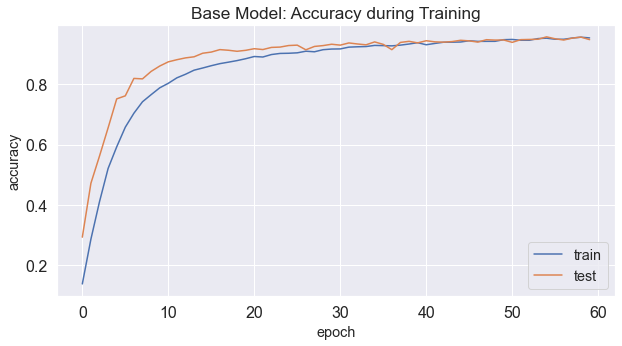

In [423]:
plt.figure(figsize=(10, 5))
plt.plot(history_base.history['accuracy'])
plt.plot(history_base.history['val_accuracy'])
plt.title('Base Model: Accuracy during Training', fontsize='xx-large')
plt.ylabel('accuracy', fontsize='x-large')
plt.xlabel('epoch', fontsize='x-large')
plt.legend(['train', 'test'], loc='lower right', fontsize='x-large')
plt.savefig('plots/train_accuracy.png')
plt.show()


In [424]:
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, top_k_accuracy_score, precision_score, f1_score, ConfusionMatrixDisplay, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def evaluate_model(model, X_test, y_test):
    # Predict probabilities for the test set
    y_pred_proba = model.predict(X_test)
    
    # class_names = [f'User {i}' for i in range(1, 188)]
    class_names = [f'{i}' for i in range(1, 187)]# + [f'{i}' for i in range(187, 188)]
    # Apply majority voting to get the final predictions
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    report = classification_report(y_test, y_pred, target_names=class_names, zero_division=0)
    conf_matrix = confusion_matrix(y_test, y_pred, labels=np.arange(1, len(class_names)+1))


    # Display results
    print(f"Accuracy: {accuracy}")
    print(f"Precision (Macro): {precision}")
    print(f"Precision (Micro): {precision_micro}")
    print(f"F1 Score (Macro): {f1_macro}")
    print(f"F1 Score (Micro): {f1_micro}")
    print("Classification Report:\n", report)

    return accuracy, precision, f1_macro, f1_micro, report, conf_matrix

a, p, f1mi, f1ma, rep, cm =evaluate_model(base_model, X_test_sequential, y_test_sequential)

146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy: 0.9582705958270595
Precision (Macro): 0.9151249172616767
Precision (Micro): 0.9582705958270595
F1 Score (Macro): 0.9046226864545577
F1 Score (Micro): 0.9582705958270595
Classification Report:
               precision    recall  f1-score   support

           1       0.67      1.00      0.80         2
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00        48
           4       0.97      0.97      0.97        60
           5       1.00      0.80      0.89         5
           6       1.00      0.92      0.96        13
           7       1.00      0.88      0.94        34
           8       0.94      1.00      0.97        17
           9       1.00      0.98      0.99        63
          10       1.00      0.96      0.98        24
          11       0.92      1.00      0.96        11
          12       0.94      0.94      0.94        16
          13       0.77      1.00      0.87        10

In [372]:
def classification_report_to_latex(report):
    """
    Converts sklearn classification report to a LaTeX table that can span multiple pages.

    Parameters:
    report (str): classification report as returned by sklearn's classification_report()

    Returns:
    str: LaTeX table as a string
    """
    # Convert the classification report to a DataFrame
    report_data = []
    lines = report.split('\n')
    for line in lines[2:]:
        row_data = line.split()
        if len(row_data) == 5:  # Only process lines with the expected number of fields
            row = {
                'class': row_data[0],
                'precision': float(row_data[1]),
                'recall': float(row_data[2]),
                'f1-score': float(row_data[3]),
                'support': int(row_data[4])
            }
            report_data.append(row)
        elif len(row_data) > 0 and row_data[0] in ['accuracy', 'macro', 'weighted']:
            # Handle accuracy, macro avg, and weighted avg separately
            if row_data[0] == 'accuracy':
                accuracy = float(row_data[1])
            elif row_data[0] == 'macro':
                macro_avg = row_data
            elif row_data[0] == 'weighted':
                weighted_avg = row_data

    df = pd.DataFrame.from_dict(report_data)
    
    # Generate LaTeX code
    latex_code = "\\begin{footnotesize}\n"
    latex_code += "\\begin{longtable}{lcccc}\n"
    latex_code += "\\caption{Classification Report} \\\\\n"
    latex_code += "\\label{tab:classification_report} \\\\\n"
    latex_code += "Class & Precision & Recall & F1-Score & Support \\\\\n"
    latex_code += "\\hline\n"
    latex_code += "\\endfirsthead\n"
    latex_code += "\\multicolumn{5}{c}{{\\bfseries \\tablename\\ \\thetable{} -- continued from previous page}} \\\\\n"
    latex_code += "Class & Precision & Recall & F1-Score & Support \\\\\n"
    latex_code += "\\hline\n"
    latex_code += "\\endhead\n"
    latex_code += "\\hline \\multicolumn{5}{r}{{Continued on next page}} \\\\\n"
    latex_code += "\\endfoot\n"
    latex_code += "\\endlastfoot\n"
    for index, row in df.iterrows():
        latex_code += f"{row['class']} & {row['precision']:.2f} & {row['recall']:.2f} & {row['f1-score']:.2f} & {row['support']} \\\\\n"
    latex_code += "\\hline\n"
    latex_code += f"Accuracy & & & {accuracy:.2f} & \\\\\n"
    latex_code += f"Macro Avg & {float(macro_avg[2]):.2f} & {float(macro_avg[3]):.2f} & {float(macro_avg[4]):.2f} & {macro_avg[5]} \\\\\n"
    latex_code += f"Weighted Avg & {float(weighted_avg[2]):.2f} & {float(weighted_avg[3]):.2f} & {float(weighted_avg[4]):.2f} & {weighted_avg[5]} \\\\\n"
    latex_code += "\\end{longtable}\n"
    latex_code += "\\end{footnotesize}"
    
    return latex_code

print(classification_report_to_latex(rep))

\begin{footnotesize}
\begin{longtable}{lcccc}
\caption{Classification Report} \\
\label{tab:classification_report} \\
Class & Precision & Recall & F1-Score & Support \\
\hline
\endfirsthead
\multicolumn{5}{c}{{\bfseries \tablename\ \thetable{} -- continued from previous page}} \\
Class & Precision & Recall & F1-Score & Support \\
\hline
\endhead
\hline \multicolumn{5}{r}{{Continued on next page}} \\
\endfoot
\endlastfoot
1 & 0.67 & 1.00 & 0.80 & 2 \\
2 & 1.00 & 1.00 & 1.00 & 6 \\
3 & 1.00 & 1.00 & 1.00 & 48 \\
4 & 0.97 & 0.97 & 0.97 & 60 \\
5 & 1.00 & 0.80 & 0.89 & 5 \\
6 & 1.00 & 0.92 & 0.96 & 13 \\
7 & 1.00 & 0.88 & 0.94 & 34 \\
8 & 0.94 & 1.00 & 0.97 & 17 \\
9 & 1.00 & 0.98 & 0.99 & 63 \\
10 & 1.00 & 0.96 & 0.98 & 24 \\
11 & 0.92 & 1.00 & 0.96 & 11 \\
12 & 0.94 & 0.94 & 0.94 & 16 \\
13 & 0.77 & 1.00 & 0.87 & 10 \\
14 & 1.00 & 1.00 & 1.00 & 1 \\
15 & 0.95 & 1.00 & 0.98 & 21 \\
16 & 1.00 & 1.00 & 1.00 & 20 \\
17 & 1.00 & 0.50 & 0.67 & 2 \\
18 & 0.95 & 0.95 & 0.95 & 20 \\
19 & 0.93 & 0

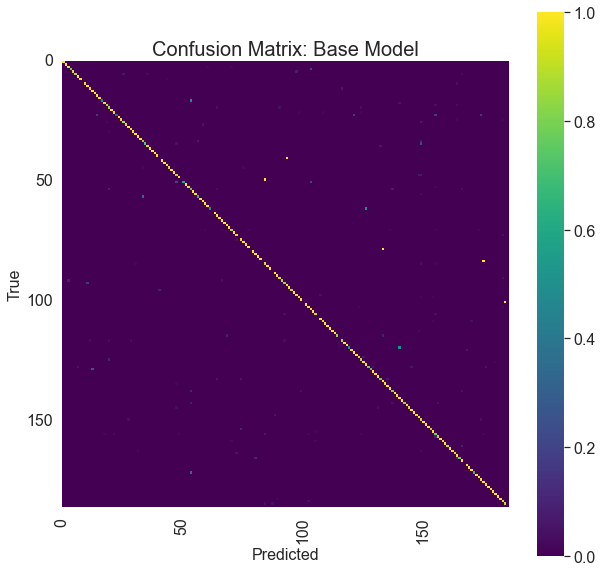

<module 'matplotlib.pyplot' from 'c:\\Users\\Lks\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [425]:
def plot_confusion_matrix(confusion_matrix, figsize=(10, 10)):
    """Plots a confusion matrix heatmap."""

    with np.errstate(divide='ignore', invalid='ignore'):
        cm_norm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        cm_norm[np.isnan(cm_norm)] = 0  # Replace NaNs with zeros
    
    # Set the overall theme including font sizes
    sns.set_theme(rc={'figure.figsize': figsize, 'font.size': 16, 'axes.titlesize': 20, 'axes.labelsize': 16,
                      'xtick.labelsize': 16, 'ytick.labelsize': 16})
    
        # Use a colorblind-friendly palette
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    # Plot the confusion matrix using seaborn
    ax = sns.heatmap(cm_norm, annot=False, cbar=True, cmap='viridis', square=True)

    # Create list of labels for every 10th label
    labels = range(0, len(confusion_matrix), 50)
    ax.set_xticks(labels)
    ax.set_yticks(labels)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix: Base Model')
    plt.savefig('plots/confusion_matrix.png')
    plt.show()

    return plt

plot_confusion_matrix(cm)

In [426]:
num_samples = X_train_sequential.shape[0]
num_timesteps = X_train_sequential.shape[1]
num_features = X_train_sequential.shape[2]

print(X_train_sequential.shape)

num_classes

(21695, 40, 4)


192

### Transfer Learning Model

In [552]:
for layer in base_model.layers: #[:-1]:   # Freeze the LSTM and Dense layers of the base
    layer.trainable = False
    
class ModelToConvert(tf.Module):
    def __init__(self):
        self.base_model = base_model

        # Create new head
        self.new_head = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation="relu", name="dense_new"),
            tf.keras.layers.Dropout(0.5, name="dropout_new", seed=RANDOM_SEED),
            tf.keras.layers.Dense(num_classes+10, activation="softmax", name="output_new")  # Increased number of classes by 10
        ], name="trainable_head")
        
        self.new_head.compile(
            loss='sparse_categorical_crossentropy',
            optimizer='adam',
            metrics=["accuracy"]
        )
        
        # Combine base model and new head
        self.model = tf.keras.Sequential([
            self.base_model,
            self.new_head
        ])
        
        self.model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )
        self.model.build(input_shape=(None, num_timesteps, num_features))

    # takes in a batch of input data and labels
    @tf.function(input_signature=[
        tf.TensorSpec(shape=[None, num_timesteps, num_features], dtype=tf.float32),
        tf.TensorSpec(shape=[None], dtype=tf.int32)
    ])
    def train(self, X, y):
        with tf.GradientTape() as tape:
            predictions = self.model(X, training=True)
            loss = self.model.compute_loss(X, y, predictions)
        
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        self.model.compiled_metrics.update_state(y, predictions)
        
        return {
            "loss": loss,
            "accuracy": self.model.metrics[1].result()['accuracy']
        }


    @tf.function(input_signature=[
        tf.TensorSpec(shape=[None, num_timesteps, num_features], dtype=tf.float32)
    ])
    def infer(self, x):
        probas = self.model(x, training=False)
        return {'probabilities': probas}

    # @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    # def save(self, checkpoint_path):
    #     tensor_names = [weight.name for weight in self.model.weights]
    #     tensors_to_save = [weight.value for weight in self.model.weights]
    #     tf.raw_ops.Save(
    #         filename=checkpoint_path, 
    #         tensor_names=tensor_names,
    #         data=tensors_to_save, 
    #         name='save')
    #     return {
    #         "checkpoint_path": checkpoint_path
    #     }

    # @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    # def restore(self, checkpoint_path):
    #     restored_tensors = {}
    #     for var in self.model.weights:
    #         restored = tf.raw_ops.Restore(
    #             file_pattern=checkpoint_path, tensor_name=var.name, dt=var.dtype,
    #             name='restore')
    #         var.assign(restored)
    #         restored_tensors[var.name] = restored

    #     for layer in self.model.layers[:5]:
    #         layer.trainable = False
    #     return restored_tensors

In [553]:
tl_model = ModelToConvert()
tl_model.model.summary(expand_nested=True)

Model: "sequential_136"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ pretrained_base (Sequential)    │ (None, 192)               │     44,672 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│    └ lstm_1 (LSTM)              │ (None, 40, 64)            │     17,664 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│    └ lstm_2 (LSTM)              │ (None, 32)                │     12,416 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│    └ dense_1 (Dense)            │ (None, 64)                │      2,112 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│    └ dropout (Dropout)          │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│    └ baselayer (Dense)          │ (None, 192)               │     12,480 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ trainable_head (Sequential)     │ (None, 202)               │     25,482 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│    └ dense_new (Dense)          │ (None, 64)                │     12,352 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│    └ dropout_new (Dropout)      │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│    └ output_new (Dense)         │ (None, 202)               │     13,130 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 70,154 (274.04 KB)

 Trainable params: 25,482 (99.54 KB)

 Non-trainable params: 44,672 (174.50 KB)

In [554]:
# how we validate the correctness of the transfer learning model
history_tl = tl_model.model.fit(
    X_train_new_user,
    y_train_new_user,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_new_user, y_test_new_user),
    callbacks=[early_stopping, tensorboard]
)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.0016 - loss: 5.2868 - val_accuracy: 0.1587 - val_loss: 5.2448
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.1096 - loss: 5.2420 - val_accuracy: 0.5238 - val_loss: 5.1993
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3550 - loss: 5.1947 - val_accuracy: 1.0000 - val_loss: 5.1519
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6767 - loss: 5.1446 - val_accuracy: 1.0000 - val_loss: 5.1013
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8785 - loss: 5.1004 - val_accuracy: 1.0000 - val_loss: 5.0464


-------

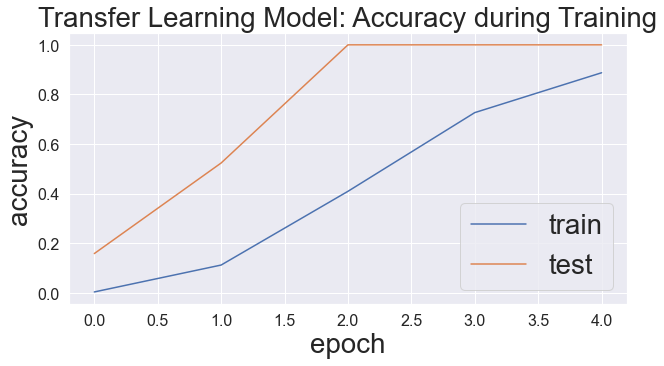

In [555]:
plt.figure(figsize=(10, 5))
plt.plot(history_tl.history['accuracy'])
plt.plot(history_tl.history['val_accuracy'])
plt.title('Transfer Learning Model: Accuracy during Training', fontsize='xx-large')
plt.ylabel('accuracy', fontsize='xx-large')
plt.xlabel('epoch', fontsize='xx-large')
plt.legend(['train', 'test'], loc='lower right', fontsize='xx-large')
plt.savefig('plots/transfer_learning_accuracy.png')
plt.show()


In [565]:
# how we would train the model on device
def on_device_training_simu(model, X_train, y_train, num_epochs=200, patience=5, min_delta=0.005):
    best_accuracy = 0
    patience_counter = 0
    for epoch in range(num_epochs):
        training_results = model.train(X_train, y_train)

        print(f"Epoch {epoch+1}: Loss = {training_results['loss']:.4f}, Accuracy = {training_results['accuracy']:.4f}")
        if training_results['accuracy'] > best_accuracy + min_delta:
            best_accuracy = training_results['accuracy']
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter > patience:
                break

    return model

tl_model_trained = on_device_training_simu(tl_model, X_train_new_user, y_train_new_user)

Epoch 1: Loss = 5.1753, Accuracy = 0.2448
Epoch 2: Loss = 5.1567, Accuracy = 0.2808
Epoch 3: Loss = 5.1524, Accuracy = 0.3134
Epoch 4: Loss = 5.1299, Accuracy = 0.3515
Epoch 5: Loss = 5.1209, Accuracy = 0.3871
Epoch 6: Loss = 5.1089, Accuracy = 0.4227
Epoch 7: Loss = 5.0932, Accuracy = 0.4562
Epoch 8: Loss = 5.0803, Accuracy = 0.4845
Epoch 9: Loss = 5.0627, Accuracy = 0.5127
Epoch 10: Loss = 5.0496, Accuracy = 0.5379
Epoch 11: Loss = 5.0359, Accuracy = 0.5615
Epoch 12: Loss = 5.0218, Accuracy = 0.5841
Epoch 13: Loss = 5.0060, Accuracy = 0.6044
Epoch 14: Loss = 4.9855, Accuracy = 0.6221
Epoch 15: Loss = 4.9710, Accuracy = 0.6389
Epoch 16: Loss = 4.9490, Accuracy = 0.6542
Epoch 17: Loss = 4.9306, Accuracy = 0.6685
Epoch 18: Loss = 4.9249, Accuracy = 0.6813
Epoch 19: Loss = 4.8951, Accuracy = 0.6934
Epoch 20: Loss = 4.8941, Accuracy = 0.7047
Epoch 21: Loss = 4.8607, Accuracy = 0.7151
Epoch 22: Loss = 4.8357, Accuracy = 0.7249
Epoch 23: Loss = 4.8061, Accuracy = 0.7340
Epoch 24: Loss = 4.7

In [566]:
# how we would infer the model on device
output = tl_model.infer(X_test_new_user)['probabilities']
# Get the majority class with tie-breaking
majority_class_with_tie_breaking = majority_voting(output)

print("Predicted Majority Class with Tie-Breaking:", majority_class_with_tie_breaking)

Predicted Majority Class with Tie-Breaking: 186


### Model Conversion

In [558]:
## testing out the model functions
model = ModelToConvert()
on_device_training_simu(model, X_train_new_user, y_train_new_user)

Epoch 1: Loss = 5.3044, Accuracy = 0.0000
Epoch 2: Loss = 5.2896, Accuracy = 0.0020
Epoch 3: Loss = 5.2838, Accuracy = 0.0027
Epoch 4: Loss = 5.2736, Accuracy = 0.0030
Epoch 5: Loss = 5.2611, Accuracy = 0.0104
Epoch 6: Loss = 5.2537, Accuracy = 0.0147
Epoch 7: Loss = 5.2399, Accuracy = 0.0189
Epoch 8: Loss = 5.2324, Accuracy = 0.0236
Epoch 9: Loss = 5.2184, Accuracy = 0.0344
Epoch 10: Loss = 5.2103, Accuracy = 0.0426
Epoch 11: Loss = 5.2017, Accuracy = 0.0606
Epoch 12: Loss = 5.1918, Accuracy = 0.0743
Epoch 13: Loss = 5.1722, Accuracy = 0.0964
Epoch 14: Loss = 5.1682, Accuracy = 0.1168
Epoch 15: Loss = 5.1580, Accuracy = 0.1427
Epoch 16: Loss = 5.1397, Accuracy = 0.1717
Epoch 17: Loss = 5.1360, Accuracy = 0.2003
Epoch 18: Loss = 5.1224, Accuracy = 0.2309
Epoch 19: Loss = 5.1080, Accuracy = 0.2608
Epoch 20: Loss = 5.0966, Accuracy = 0.2910
Epoch 21: Loss = 5.0920, Accuracy = 0.3186
Epoch 22: Loss = 5.0759, Accuracy = 0.3465
Epoch 23: Loss = 5.0679, Accuracy = 0.3719
Epoch 24: Loss = 5.0

In [567]:
pred = model.infer(X_test_new_user)['probabilities']
majority_voting(pred)


186

In [560]:
# model.save('model_checkpoint')


In [387]:
# model.restore('model_checkpoint')

In [561]:
def convert_and_save(saved_model_dir='saved_model'):
    """Converts and saves the TFLite Transfer Learning model.

    Args:
    saved_model_dir: A directory path to save a converted model.
    """
    model = ModelToConvert()

    tf.saved_model.save(
        model,
        saved_model_dir,
        signatures={
            'train': model.train.get_concrete_function(),
            'infer': model.infer.get_concrete_function(),
            # 'save': model.save.get_concrete_function(),
            # 'restore': model.restore.get_concrete_function(),
        })

    # Convert the model
    converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
        tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
    ]
    converter.experimental_enable_resource_variables = True
    tflite_model = converter.convert()

    model_file_path = os.path.join('model.tflite')
    with open(model_file_path, 'wb') as model_file:
        model_file.write(tflite_model)


In [562]:
saved_model_dir = 'saved_stacked_model'
convert_and_save(saved_model_dir)

c:\Users\Lks\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\trainer.py:579: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


AssertionError: Tried to export a function which references an 'untracked' resource. TensorFlow objects (e.g. tf.Variable) captured by functions must be 'tracked' by assigning them to an attribute of a tracked object or assigned to an attribute of the main object directly. See the information below:
	Function name = b'__inference_signature_wrapper_2576505'
	Captured Tensor = <ResourceHandle(name="seed_generator_state/2386", device="/job:localhost/replica:0/task:0/device:CPU:0", container="Anonymous", type="class tensorflow::Var", dtype and shapes : "[ DType enum: 22, Shape: [2] ]")>
	Trackable referencing this tensor = <tf.Variable 'seed_generator_state:0' shape=(2,) dtype=uint32>
	Internal Tensor = Tensor("2576457:0", shape=(), dtype=resource)